In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install facenet-pytorch

In [ ]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
import os
from facenet_pytorch import MTCNN
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
source_folder = "/content/drive/MyDrive/vgg16"
train_folder = "/content/drive/MyDrive/vgg16/train"
test_folder = "/content/drive/MyDrive/vgg16/test"

if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

def copy_image(image_name, source_folder, destination_folder):
    source_image_path = os.path.join(source_folder, image_name)
    destination_image_path = os.path.join(destination_folder, image_name)
    shutil.copyfile(source_image_path, destination_image_path)

for folder_name in os.listdir(source_folder):
    folder_path = os.path.join(source_folder, folder_name)
    if os.path.isdir(folder_path):
        train_folder_path = os.path.join(train_folder, folder_name)
        test_folder_path = os.path.join(test_folder, folder_name)
        if not os.path.exists(train_folder_path):
            os.makedirs(train_folder_path)
        if not os.path.exists(test_folder_path):
            os.makedirs(test_folder_path)
        images = os.listdir(folder_path)
        train_images = images[:int(0.8*len(images))]
        test_images = images[int(0.8*len(images)):]
        for image in train_images:
            copy_image(image, folder_path, train_folder_path)

        for image in test_images:
            copy_image(image, folder_path, test_folder_path)


In [ ]:
class FaceDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.imgs = []
        self.mtcnn = MTCNN(image_size=224, margin=0, min_face_size=20)


        for label in os.listdir(data_folder):
            label_folder = os.path.join(data_folder, label)
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                if label == 'ImposterRaw':
                    self.imgs.append((img_path, 0))
                elif label == 'ClientRaw':
                    self.imgs.append((img_path, 1))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        boxes, _ = self.mtcnn.detect(img)
        if boxes is not None:
            box = boxes[0]
            face_img = self.transform(img.crop(box))
        else:
            face_img = self.transform(img)

        return face_img, label


In [ ]:

train_folder = "/content/drive/MyDrive/vgg16/train"
test_folder = "/content/drive/MyDrive/vgg16/test"
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transformations = {
    'train': transforms.Compose([
         transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

train_dataset = FaceDataset(train_folder, transform=transformations['train'])
test_dataset = FaceDataset(test_folder,transform=transformations['test'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:


model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = 25088
classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 2),
    nn.Softmax(dim=1)
)
model.classifier = classifier


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
val_predictions = []
val_labels = []
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_one_epoch(epoch_index):
    running_loss = 0.
    running_accuracy = 0.
    last_loss = 0.
    last_accuracy = 0.


    for i, data in enumerate(train_loader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.max(outputs.data, 1)[1]
        accuracy = torch.mean(torch.eq(labels, preds).float())
        running_loss += loss.item()
        running_accuracy += accuracy


    avg_loss = running_loss / len(train_loader)
    avg_accuracy = running_accuracy / len(train_loader)
    return avg_loss, avg_accuracy



epoch_number = 0

EPOCHS = 10
best_model = None
best_vloss = 1_000_000.

early_stopping_patience = 5
early_stopping_epochs = 0
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss, avg_accuracy = train_one_epoch(epoch_number)
    model.train(False)

    running_vloss = 0.0
    running_vaccuracy = 0.0
    num_vsamples = 0

    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        voutputs = model(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss.item()
        vpredictions = torch.max(voutputs.data, 1)[1]
        vacc = accuracy = torch.mean(torch.eq(vlabels, vpredictions).float())
        running_vaccuracy += vacc * vinputs.shape[0]
        num_vsamples += vinputs.shape[0]
        val_predictions.append(vpredictions.detach())
        val_labels.append(vlabels.detach())
    avg_vloss = running_vloss / (i + 1)
    scheduler.step(avg_vloss)
    avg_vaccuracy = running_vaccuracy / num_vsamples
    print('LOSS train {:.2f}% valid {:.2f}% | ACCURACY train {:.2f}% valid {:.2f}%'.format(avg_loss*100, avg_vloss*100, avg_accuracy*100, avg_vaccuracy*100))
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    val_losses.append(avg_vloss)
    val_accuracies.append(avg_vaccuracy)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model = model.state_dict()
    epoch_number += 1



EPOCH 1:
LOSS train 32.53% valid 31.72% | ACCURACY train 98.78% valid 99.60%
EPOCH 2:
LOSS train 31.48% valid 31.48% | ACCURACY train 99.86% valid 99.84%
EPOCH 3:
LOSS train 31.51% valid 31.36% | ACCURACY train 99.81% valid 100.00%
EPOCH 4:
LOSS train 31.39% valid 31.62% | ACCURACY train 99.91% valid 99.72%
EPOCH 5:
LOSS train 31.66% valid 34.55% | ACCURACY train 99.67% valid 96.63%
EPOCH 6:
LOSS train 31.38% valid 31.33% | ACCURACY train 99.95% valid 100.00%
EPOCH 7:
LOSS train 31.66% valid 31.37% | ACCURACY train 99.65% valid 99.96%
EPOCH 8:
LOSS train 31.37% valid 31.39% | ACCURACY train 99.95% valid 99.96%
EPOCH 9:
LOSS train 31.79% valid 31.42% | ACCURACY train 99.52% valid 99.92%
EPOCH 10:
LOSS train 31.69% valid 31.44% | ACCURACY train 99.62% valid 99.88%


<ipython-input-14-e4135bc55feb>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_accuracies = torch.tensor(train_accuracies)
<ipython-input-14-e4135bc55feb>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_accuracies = torch.tensor(val_accuracies)
<ipython-input-14-e4135bc55feb>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.tensor(train_losses)
<ipython-input-14-e4135bc55feb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().det

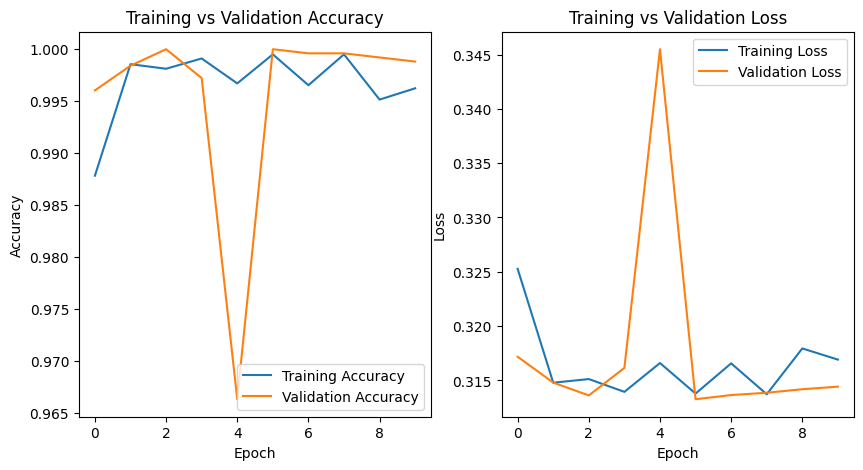

In [ ]:

train_accuracies = torch.tensor(train_accuracies)
val_accuracies = torch.tensor(val_accuracies)
train_losses = torch.tensor(train_losses)
val_losses = torch.tensor(val_losses)
train_accuracies_np = train_accuracies.detach().cpu().numpy()
val_accuracies_np = val_accuracies.detach().cpu().numpy()
train_losses_np = train_losses.detach().cpu().numpy()
val_losses_np = val_losses.detach().cpu().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_accuracies_np, label='Training Accuracy')
axs[0].plot(val_accuracies_np, label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training vs Validation Accuracy')
axs[0].legend()

axs[1].plot(train_losses_np, label='Training Loss')
axs[1].plot(val_losses_np, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training vs Validation Loss')
axs[1].legend()

plt.show()

In [ ]:
torch.save(best_model, '/content/drive/MyDrive/FaceSpoof.pth')

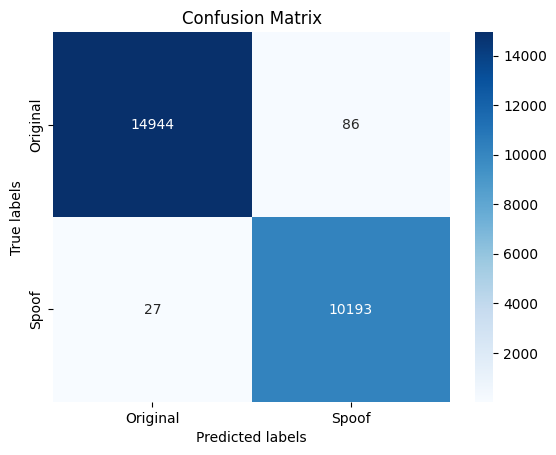


Accuracy: 0.9955


In [ ]:

val_predictions_concat = torch.cat(val_predictions, dim=0)
val_labels_concat = torch.cat(val_labels, dim=0)
val_predictions_cpu = val_predictions_concat.cpu().numpy()
val_labels_cpu = val_labels_concat.cpu().numpy()
tick_labels = ["Original","Spoof"]
cm = confusion_matrix(val_labels_cpu, val_predictions_cpu)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tick_labels, yticklabels=tick_labels)
accuracy = accuracy_score(val_labels_cpu, val_predictions_cpu)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
print()
print("Accuracy:", round(accuracy,4))

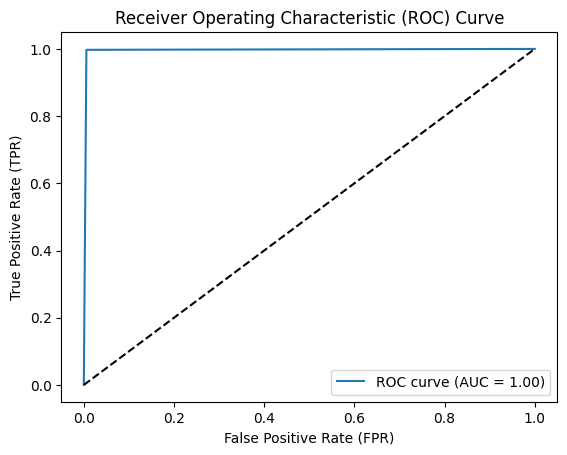


False Acceptance Rate (FAR): 0.0026
False Rejection Rate (FRR): 0.0057
Half Total Error Rate (HTER): 0.0042
Equal Error Rate (EER): 0.0057


In [ ]:
from sklearn.metrics import roc_curve, auc

TP = cm[0, 0]
FP = cm[1, 0]
TN = cm[1, 1]
FN = cm[0, 1]

FAR = FP / (FP + TN)

FRR = FN / (FN + TP)

HTER = (FAR + FRR) / 2

fpr, tpr, thresholds = roc_curve(val_labels_cpu, val_predictions_cpu)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
print()


eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
eer_index = np.where(thresholds == eer_threshold)[0][0]
eer = fpr[eer_index]

print("False Acceptance Rate (FAR):", round(FAR,4))
print("False Rejection Rate (FRR):", round(FRR,4))
print("Half Total Error Rate (HTER):", round(HTER,4))
print("Equal Error Rate (EER):", round(eer, 4))

 **VALIDATION ON LCC-FASD DATASET**




In [ ]:
from torchvision import models, transforms
import torch.nn as nn
import torch

model = models.vgg16(pretrained=True)
num_features = 25088
classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 2),
    nn.Softmax(dim=1)
)
model.classifier = classifier
state_dict = torch.load('/content/drive/MyDrive/FaceSpoof.pth')
model.load_state_dict(state_dict)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
mtcnn = MTCNN(image_size=224, margin=0, min_face_size=20)
model.eval()
predictions = []
labels = []

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

real_images_dir = '/content/drive/MyDrive/Cross validation/Real'
for filename in os.listdir(real_images_dir):
    image = Image.open(os.path.join(real_images_dir, filename)).convert('RGB')
    boxes, _ = mtcnn.detect(image)
    if boxes is not None:
      box = boxes[0]
      face_img = image.crop(box)
      face_tensor = transform(face_img).unsqueeze(0)
      output = model(face_tensor)
      probabilities = torch.softmax(output, dim=1)
      predicted_label = torch.argmax(probabilities, dim=1)
      predictions.append(predicted_label.item())
      labels.append(1)



spoof_images_dir = '/content/drive/MyDrive/Cross validation/Spoof'
for filename in os.listdir(spoof_images_dir):
    image = Image.open(os.path.join(spoof_images_dir, filename)).convert('RGB')
    boxes, _ = mtcnn.detect(image)
    if boxes is not None:
      box = boxes[0]
      face_img = image.crop(box)
      face_tensor = transform(face_img).unsqueeze(0)
      output = model(face_tensor)
      probabilities = torch.softmax(output, dim=1)
      predicted_label = torch.argmax(probabilities, dim=1)
      predictions.append(predicted_label.item())
      labels.append(0)

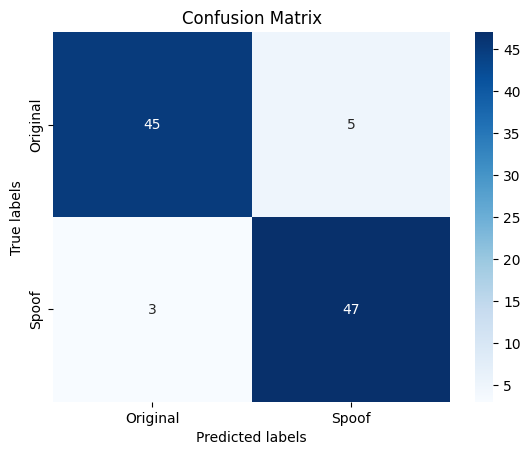


Accuracy: 0.92


In [ ]:
accuracy = accuracy_score(labels, predictions)

tick_labels = ["Original","Spoof"]
cm1 = confusion_matrix(labels, predictions)
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
print()
print("Accuracy:", accuracy)


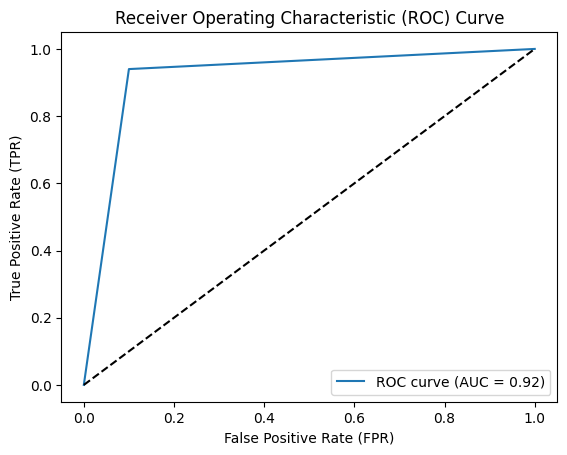


False Acceptance Rate (FAR): 0.06
False Rejection Rate (FRR): 0.1
Half Total Error Rate (HTER): 0.08
Equal Error Rate (EER): 0.1


In [ ]:
from sklearn.metrics import roc_curve, auc

TP = cm1[0, 0]
FP = cm1[1, 0]
TN = cm1[1, 1]
FN = cm1[0, 1]

FAR = FP / (FP + TN)

FRR = FN / (FN + TP)

HTER = (FAR + FRR) / 2

fpr, tpr, thresholds = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
print()
eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
eer_index = np.where(thresholds == eer_threshold)[0][0]
eer = fpr[eer_index]

print("False Acceptance Rate (FAR):", round(FAR,4))
print("False Rejection Rate (FRR):", round(FRR,4))
print("Half Total Error Rate (HTER):", round(HTER,4))
print("Equal Error Rate (EER):", round(eer, 4))